In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

import os

In [16]:
cwd = os.getcwd()
fp = os.path.join(cwd,'data/HCP500_rfMRI_motion.txt')
hcp=np.loadtxt(fp)
fp = os.path.join(cwd,'data/mean_FDs.txt')
abcd=np.loadtxt(fp)

# for ABCD, change nan --> 0
abcd[np.isnan(abcd)]=0

In [17]:
# mean and SD
hcp_mu = np.mean(hcp)
hcp_sigma = np.std(hcp)

abcd_mu = np.mean(abcd)
abcd_sigma = np.std(abcd)

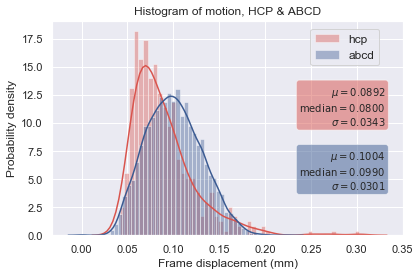

In [111]:
bins=51
fig, ax = plt.subplots()

# Call the sns.set() function 
sns.set()
sns.distplot(hcp,bins=bins,norm_hist=True,label='hcp',color=sns.xkcd_rgb["pale red"])
sns.distplot(abcd,bins=bins,norm_hist=True,label='abcd',color=sns.xkcd_rgb["denim blue"])

# plt.axvline(np.median(hcp), linestyle='--',color=sns.xkcd_rgb["pale red"])
# plt.axvline(np.median(abcd), linestyle='--',color=sns.xkcd_rgb["denim blue"])

plt.legend(loc='upper right', bbox_to_anchor=(0.95, 0.99),fontsize=12)

ax.set_xlabel('Frame displacement (mm)')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of motion, HCP & ABCD')

textstr1 = '\n'.join((
    r'$\mu=%.4f$' % (hcp_mu, ),
    r'$\mathrm{median}=%.4f$' % (np.median(hcp), ),
    r'$\sigma=%.4f$' % (hcp_sigma, )))

textstr2 = '\n'.join((
    r'$\mu=%.4f$' % (abcd_mu, ),
    r'$\mathrm{median}=%.4f$' % (np.median(abcd), ),
    r'$\sigma=%.4f$' % (abcd_sigma, )))

props1 = dict(boxstyle='round', facecolor=sns.xkcd_rgb["pale red"], alpha=0.5)
props2 = dict(boxstyle='round', facecolor=sns.xkcd_rgb["denim blue"], alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.95, 0.7, textstr1, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props1)
# place a text box in upper left in axes coords
ax.text(0.95, 0.4, textstr2, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props2)

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

In [ ]:
fd=0.3
zscore = (0.3-mu)/sigma
zscore